In [10]:
import os
import torch
import torch.nn as nn
import torchvision 
from torch.nn import Linear
from torch import optim
import pandas as pd
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from mpl_toolkits import mplot3d
%matplotlib inline
torch.set_printoptions(threshold=50,edgeitems=300,linewidth=100)
import math
import statistics 
import optuna
# import plotly
torch.set_default_dtype(torch.float64)
import jovian
import torchvision.transforms

In [11]:
torch.cuda.is_available()

False

In [12]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
torch.cuda.device_count()


Running on the CPU


0

In [13]:
coord_all = np.load("./03_Kreuznapf/coord_all_81000001.npy")
disp_all = np.load("./03_Kreuznapf/disp_all_81000001.npy")


In [14]:

disp_all = torch.tensor(disp_all, dtype=torch.float64)
print(disp_all.shape)
print(torch.min(disp_all))
print(torch.max(disp_all))
print(torch.mean(disp_all))

Norm = torchvision.transforms.Normalize((disp_all[:,:,0].mean(),disp_all[:,:,1].mean(),disp_all[:,:,2].mean()),(disp_all[:,:,0].std(),disp_all[:,:,1].std(),disp_all[:,:,2].std()))
Norm1 = torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))


torch.Size([249, 4981, 3])
tensor(-138.5823)
tensor(159.2684)
tensor(-7.7699)


In [15]:
tran = disp_all.T
y1 = Norm(tran)
print(y1[2,:,:].std())
print(torch.min(y1[1,:,:]))
print(torch.max(y1))
print(torch.mean(y1))
print(disp_all[:,:,0].std())
y1 = y1.T

tensor(1.0000)
tensor(-3.1509)
tensor(2.6380)
tensor(9.3130e-17)
tensor(37.2342)


In [16]:
print(y1[0:10,0,:])

tensor([[ 2.3755,  1.6843, -0.2108],
        [ 2.0349,  1.6843, -0.9565],
        [ 2.0472,  1.6843, -1.2380],
        [ 2.3114,  1.6843, -0.4591],
        [ 2.0090,  1.6843, -0.9321],
        [ 2.3775,  1.6843, -0.3581],
        [ 1.7862,  1.6843, -1.4898],
        [ 1.9698,  1.6843, -1.0139],
        [ 1.8722,  1.6843, -1.6150],
        [ 2.2315,  1.6843, -0.4474]])


In [9]:
for exp in range(2):
    fig = plt.figure(figsize=(10,10))
    xi = y1[exp,:,0]
    yi = y1[exp,:,1]
    zi = y1[exp,:,2]
    ax = fig.add_subplot(projection='3d')
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    ax.scatter3D(xi, yi, zi, c=zi, cmap='nipy_spectral')
    ax.view_init(elev=45,azim=0)
    plt.show()
    
    
    #(np.random.randint(1,249,10))

NameError: name 'y1' is not defined

<Figure size 720x720 with 0 Axes>

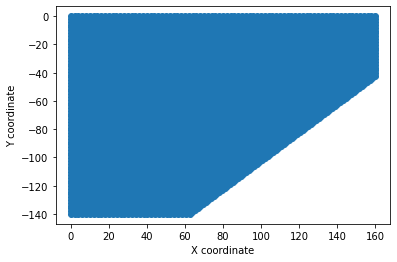

In [9]:
exp = 5
fig = plt.figure()
xi = coord_all[exp,:,0]
yi = coord_all[exp,:,1]
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.scatter(xi,yi)
plt.show() 

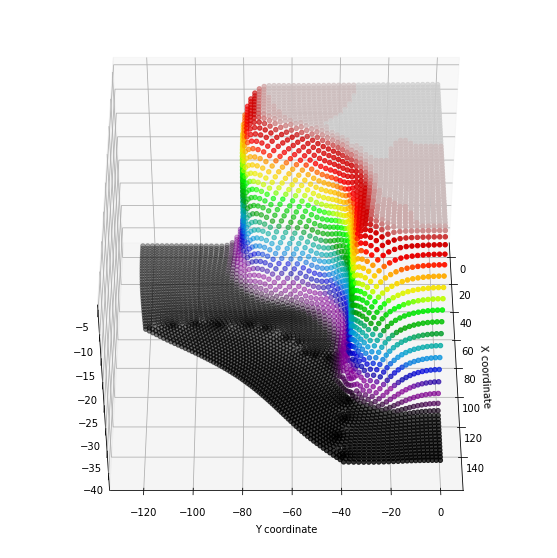

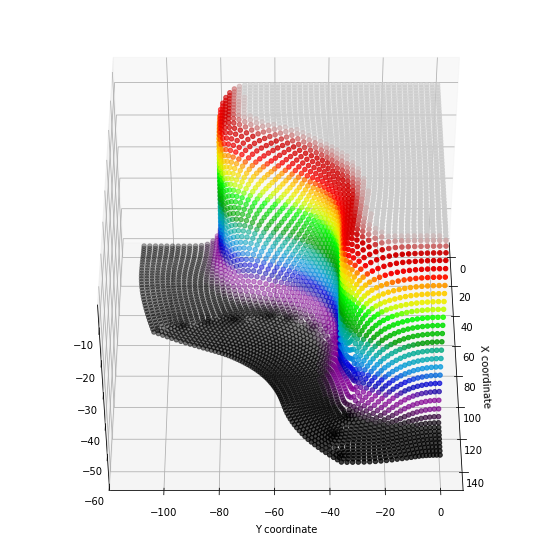

In [8]:
for exp in range(2):
    fig = plt.figure(figsize=(10,10))
    xi = disp_all[exp,:,0]
    yi = disp_all[exp,:,1]
    zi = disp_all[exp,:,2]
    ax = fig.add_subplot(projection='3d')
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    ax.scatter3D(xi, yi, zi, c=zi, cmap='nipy_spectral')
    ax.view_init(elev=45,azim=0)
    plt.show()
    
    
    #(np.random.randint(1,249,10))

### Data Processing

In [1]:
from torch.utils.data import Dataset, DataLoader
   


class Geom_Dataset(Dataset):
    def __init__(self): #transform=None
        super().__init__()
        
        ## here you can add the file path
        self.data_name=pd.read_csv('C:/Users/sneha/Downloads/Downloads/Jypyter/files/03_Kreuznapf/Experiments_1_without_Error_Term.csv', sep=';', decimal=',')
        self.x = torch.tensor(self.data_name[['F_press','fs','h_BT']].values, dtype = torch.float64)
        print("size of input is ",self.x.size())

        #Output
        disp_all = np.load("C:/Users/sneha/Downloads/Downloads/Jypyter/files/03_Kreuznapf/disp_all_81000001.npy")
        self.y = torch.tensor(disp_all.reshape(249,-1,order = 'F'), dtype=torch.float64)
        print(self.y.size())
        print("size of output is \n",self.y.size())
        print(self.data_name.head())
        self.len = self.x.shape[0]
        
    def __len__(self):
        return self.len
     
    def __getitem__(self, index):

        return self.x[index],self.y[index]
    
data = Geom_Dataset()


NameError: name 'pd' is not defined

### splitting data into train and vaidation

In [10]:
val_size = 50
train_size = len(data) - val_size
train_ds, val_ds = random_split(data, [train_size, val_size])
print("the train size is {} and validation size is {} ".format(len(train_ds), len(val_ds)))

batch_size = 249
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size) 


the train size is 199 and validation size is 50 


### Defining the Model
https://www.coursera.org/learn/deep-neural-networks-with-pytorch/home/welcome

In [11]:
class My_Model(nn.Module):
    def __init__(self, in_size, h,s,outsize, p=0):
        
        super(My_Model,self). __init__()
        self.in_size = in_size
        self.outsize = outsize
        self.h = h
        self.s = s
        self.hidden=nn.ModuleList()
        self.drop=nn.Dropout(p=p)
        self.Layers = [in_size, *[self.s for i in range(h)], outsize]
        print(self.Layers)
        self.norm = nn.BatchNorm1d(s)
        for input_size,output_size in zip(self.Layers, self.Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            
    def forward(self, activation):
        L=len(self.hidden)
        for(l,linear_transform) in zip(range(L),self.hidden):
            if l<L-1:
            
                activation = linear_transform(activation)
                activation=torch.relu(self.norm(activation))
                activation=self.drop(activation)
            else:
                activation= linear_transform(activation)
        return activation

In [12]:
from torch_lr_finder import LRFinder

def lrfinder(model):
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
    lr_finder = LRFinder(model, optimizer, MSE, device=device)
    lr_finder.range_test(train_loader, end_lr=100, num_iter=50)
    lr_finder.reset() # to reset the model and optimizer to their initial state
    ax, lr = lr_finder.plot() # to inspect the loss-learning rate graph
    return lr


### Training
https://www.coursera.org/learn/deep-neural-networks-with-pytorch/home/welcome

In [13]:


def train(model,train_loader, val_loader, optimizer, epochs):
    model.to(device)
    total_loss = {'training_loss':[],'validation_loss':[]}
    for epoch in range(epochs):
        batch_loss=[]
        for i,(x,y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            yhat = model(x)
            loss = MSE(y,yhat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss.append(torch.sqrt(loss).item())
        total_loss['training_loss'].append(torch.Tensor(batch_loss).mean().item())
#         print(total_loss['training_loss'])
  
        with torch.no_grad():
            model.eval()
            batch_loss=[]        
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)
                yhat = model(x)
                loss = MSE(y,yhat)
                batch_loss.append(torch.sqrt(loss).item())
            total_loss['validation_loss'].append(torch.Tensor(batch_loss).mean().item()) 
#             print(total_loss['validation_loss'])

        #if total_loss['training_loss'][epoch]>total_loss['training_loss'][epoch-1] and total_loss['validation_loss'][epoch]>total_loss['validation_loss'][epoch-1]:
            #break
    return total_loss


### Calculate R squared score

In [14]:
from sklearn.metrics import r2_score

def r2score(model):
    x = data[:][0].to(device)
    y = data[:][1].detach().to(device)
    yhat= model(x).detach().to(device)
    r2_score= 1- (torch.sum((y-yhat)**2)/torch.sum((y-y.float().mean())**2))
    print("R squared score is",r2_score)
    return r2_score.item()


### single model with random inputs

In [15]:
epochs = 60
in_size = 3 
outsize = 14943
h = 5
s = 500
torch.manual_seed(888)
MSE = nn.MSELoss()
model = My_Model(in_size, h,s,outsize, p=0).to(device)
print(model)
optimizer = optim.RMSprop(model.parameters(), lr=0.0271) # weight_decay= 1e-3
total_loss= train(model,train_loader, val_loader, optimizer, epochs)
for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
    print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))

if torch.cuda.is_available():
    torch.cuda.empty_cache()


[3, 500, 500, 500, 500, 500, 14943]
My_Model(
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): Linear(in_features=500, out_features=14943, bias=True)
  )
  (drop): Dropout(p=0, inplace=False)
  (norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
training_loss:57.93,     validation_loss:43.49
training_loss:43.47,     validation_loss:21.29
training_loss:21.29,     validation_loss:14.19
training_loss:13.97,     validation_loss:14.01
training_loss:13.76,     validation_loss:15.16
training_loss:14.87,     validation_loss:11.00
training_loss:10.64,     validation_loss:11.81
training_loss:11.42,     validation_loss:9.21
training_loss:8.74,     validation_loss:9.08
tra

In [16]:
x = data[:][0].to(device)
yhat = model(x)
print(yhat[0])
exp = 1
print(yhat.size())
yhat1 = yhat[0].reshape(-1,3)



tensor([ 1.4784e+02, -1.1190e-01,  3.0563e+00,  5.5392e+00,  8.3390e+00,  1.0737e+01,  1.2288e+01,
         1.5128e+01,  1.7757e+01,  2.0183e+01,  2.2572e+01,  2.4799e+01,  2.6934e+01,  2.9088e+01,
         3.1246e+01,  3.3457e+01,  3.5667e+01,  3.7896e+01,  4.0121e+01,  4.2343e+01,  4.4585e+01,
         4.6811e+01,  4.9065e+01,  5.1301e+01,  5.3547e+01,  5.5803e+01,  5.8057e+01,  6.0313e+01,
         6.2564e+01,  6.4814e+01,  6.7059e+01,  6.9286e+01,  7.1524e+01,  7.3748e+01,  7.5937e+01,
         7.8169e+01,  8.0337e+01,  8.2530e+01,  8.4698e+01,  8.6907e+01,  8.9075e+01,  9.1281e+01,
         9.3460e+01,  9.5659e+01,  9.7849e+01,  1.0004e+02,  1.0227e+02,  1.0443e+02,  1.0662e+02,
         1.0881e+02,  1.1096e+02,  1.1299e+02,  1.1481e+02,  1.1634e+02,  1.1747e+02,  1.1820e+02,
         1.1855e+02,  1.1860e+02,  1.1871e+02,  1.1875e+02,  1.1883e+02,  1.1894e+02,  1.1905e+02,
         1.1920e+02,  1.1938e+02,  1.1972e+02,  1.2021e+02,  1.2096e+02,  1.2191e+02,  1.2308e+02,
         1

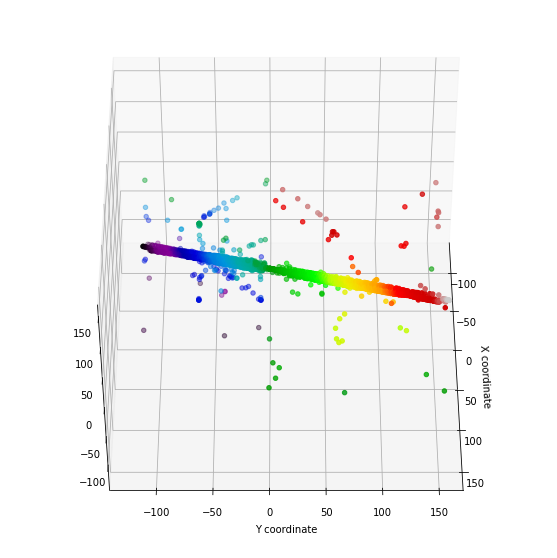

In [17]:
fig = plt.figure(figsize=(10,10))
xi = yhat1[:,0].detach().numpy()
yi = yhat1[:,1].detach().numpy()
zi = yhat1[:,2].detach().numpy()
ax = fig.add_subplot(projection='3d')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
ax.scatter3D(xi, yi, zi, c=zi, cmap='nipy_spectral')
ax.view_init(elev=45,azim=0)
plt.show()


#(np.random.randint(1,249,10))

### training and Validation loss vs epochs

ValueError: x and y must have same first dimension, but have shapes (30,) and (60,)

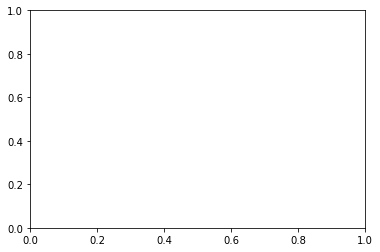

In [18]:
epochs = 30
epochs = range(1,epochs+1)
plt.plot(epochs, total_loss['training_loss'], 'g', label='Training loss')
plt.plot(epochs, total_loss['validation_loss'], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### to find the best hyperparameters from OPTUNA
https://optuna.readthedocs.io/en/stable/tutorial/index.html

In [ ]:
MSE = nn.MSELoss()

def objective(trial):
    epochs = 30
    in_size = 3 
    outsize = 14943
    h = trial.suggest_int("n_layers", 1,4)
    print(h)
    p = 0 #trial.suggest_float("n_units_l{}".format(h),0.2,0.5)
    print(p)
    s = 500 #trial.suggest_int("hidden layer size",400,1000)
    torch.manual_seed(849454)
    model = My_Model(in_size, h,s,outsize, p).to(device)
    print(model)
    lrfder = trial.suggest_float("lr",1e-5,1e-1)
    print(lrfder)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
    print(optimizer_name)
    optimizer = getattr(optim,optimizer_name)(model.parameters(), lr=lrfder)# weight_decay= 1e-3
    total_loss= train(model,train_loader, val_loader, optimizer, epochs)

    for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
        print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))
    trial.report(total_loss['validation_loss'][-1], epochs)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return total_loss['validation_loss'][-1]
study = optuna.create_study()
study.optimize(objective,n_trials = 10) 

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective,n_trials=400, timeout = 600)
    
    pruned_trials = (t for t in study.trials if t.state ==optuna.trial.TrialState.PRUNED)
    complete_trials = (t for t in study.trials if t.state ==optuna.trial.TrialState.PRUNED)
    
    

In [ ]:
print("study statistics")
print("number of finished trials:", len(study.trials))
print("number of pruned trials:", pruned_trials)
print("number of complete trials:", complete_trials)

print("best trials:")
trial = study.best_trial
print("Value:", trial.values)

print("param:")
for key,value in trial.params.items():
    print("{}:{}".format(key,value))

In [ ]:
optuna.visualization.plot_intermediate_values(study)

### Saving the model and printing R2 score

In [ ]:
r =torch.as_tensor(r2score(model))
torch.save(r, "./Rscore.pt")
loaded = torch.load("./Rscore.pt")
torch.save(model.state_dict(), './model_{}.ckpt'.format(h))
# model = My_Model(in_size, h,s,outsize, p=0.2)
# model.load_state_dict(torch.load('./model_{}.ckpt'.format(h)))


### Initialisation

In [ ]:
seed_list = np.array([9,89,232,5688,87843,216848,9867985,65468935,135878968,9999999999])
r2_score = np.zeros((7,10))
epochs = 30
in_size = 3 
outsize = 14943
s = 500

### Hyperparameter tuning

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

for j, h in enumerate(range(1,8)):
    for k,seed in enumerate(seed_list):
        torch.manual_seed(seed)
        print("\n hidden layer = {} seed = {}" .format(h,seed))
        MSE = nn.MSELoss()
        model = My_Model(in_size, h,s,outsize,  p=0.20).to(device)
        lrfder = lrfinder(model)
        optimizer = optim.RMSprop(model.parameters(), lr=lrfder, weight_decay= 1e-3)
        total_loss= train(model, train_loader, val_loader, optimizer,epochs)
        for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
            print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))
        r2_score[j,k] = r2score(model)
        torch.save(model.state_dict(), '/home/sneha/Downloads/Jypyter/files/Hemispherical/Model properties/model_{}_{}.ckpt'.format(h,seed))

torch.save(r2_score, "/home/sneha/Downloads/Jypyter/files/Hemispherical/Model properties/Rscore1.pt")

end.record()
torch.cuda.synchronize()
print("time taken to run this program is {:0.4f} seconds" .format(start.elapsed_time(end)))
torch.cuda.empty_cache()


In [ ]:
r2_score = torch.load("/home/sneha/Downloads/Jypyter/files/Hemispherical/Model properties/Rscore")
print(r2_score)
fig = plt.figure(figsize=(6,6))
r=[]
for i in range(7):
        r.append(r2_score[i][:])
    
plt.ylim(ymin=0, ymax=1)
plt.boxplot(r)
plt.xlabel('models')
plt.ylabel('r squared score')
plt.show()



In [ ]:
surrogate model vs model instead of optuna

In [ ]:
jovian.commit()

In [ ]:
NORMALISE DATA
optuna look into the model 
and the range of parameter why
predict geometery according to the output
orgnal vs the output plot

add different views
normalisation view
test sets parameters 
documentation of arriavial of output  eg how lr range
low f_press